In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20180202':]
#contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9916.21218117854

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2018-02-02 01:47:00,6954.00,6963.50,6941.25,6942.25,5137,9882
1,2018-02-02 03:50:00,6942.25,6946.25,6912.50,6935.25,5661,9963
2,2018-02-02 07:59:00,6936.00,6944.00,6925.25,6932.75,5818,10003
3,2018-02-02 09:59:00,6932.75,6939.75,6896.25,6898.75,5481,9693
4,2018-02-02 10:54:00,6899.00,6899.50,6869.00,6869.50,5710,10460
...,...,...,...,...,...,...,...
17724,2019-09-04 17:11:00,7681.00,7686.75,7676.25,7685.50,5166,10140
17725,2019-09-04 17:28:00,7685.75,7691.00,7679.50,7688.50,4512,9468
17726,2019-09-04 17:42:00,7688.75,7702.75,7688.75,7701.25,5233,11112


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)

In [7]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()
data['breakout_norm_mean'] = data['breakout_norm'].ewm(span=smooth).mean()

In [8]:
data['carver'] = (data.close - data['mid']) / (data['max'] - data['min'])
data['carver_mean'] = data['carver'].ewm(span=smooth).mean() 

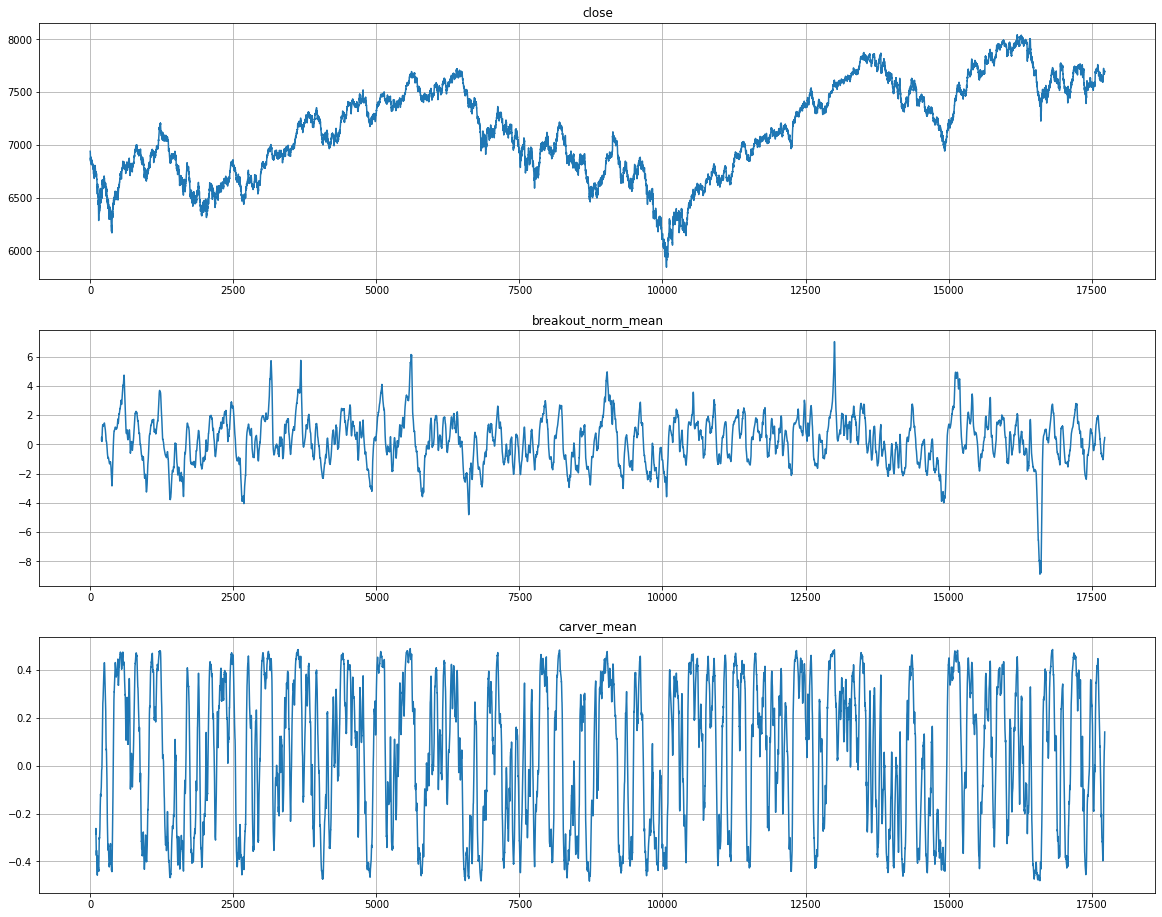

In [9]:
plot(data[['close', 'breakout_norm_mean', 'carver_mean']])

In [10]:
data['ema_fast'] = data.close.ewm(span=periods).mean()
data['ema_slow'] = data.close.ewm(span=periods*3).mean()
data['ema_diff'] = data.ema_fast - data.ema_slow
data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
data['ema_diff_norm_mean'] = data['ema_diff_norm'].ewm(span=smooth).mean()

In [11]:
data['roc'] = (data.close / data.close.shift(2)) -1
data['roc_norm'] = data.roc / data.roc.rolling(periods).std()
data['roc_norm_mean'] = data['roc_norm'].ewm(span=smooth).mean()

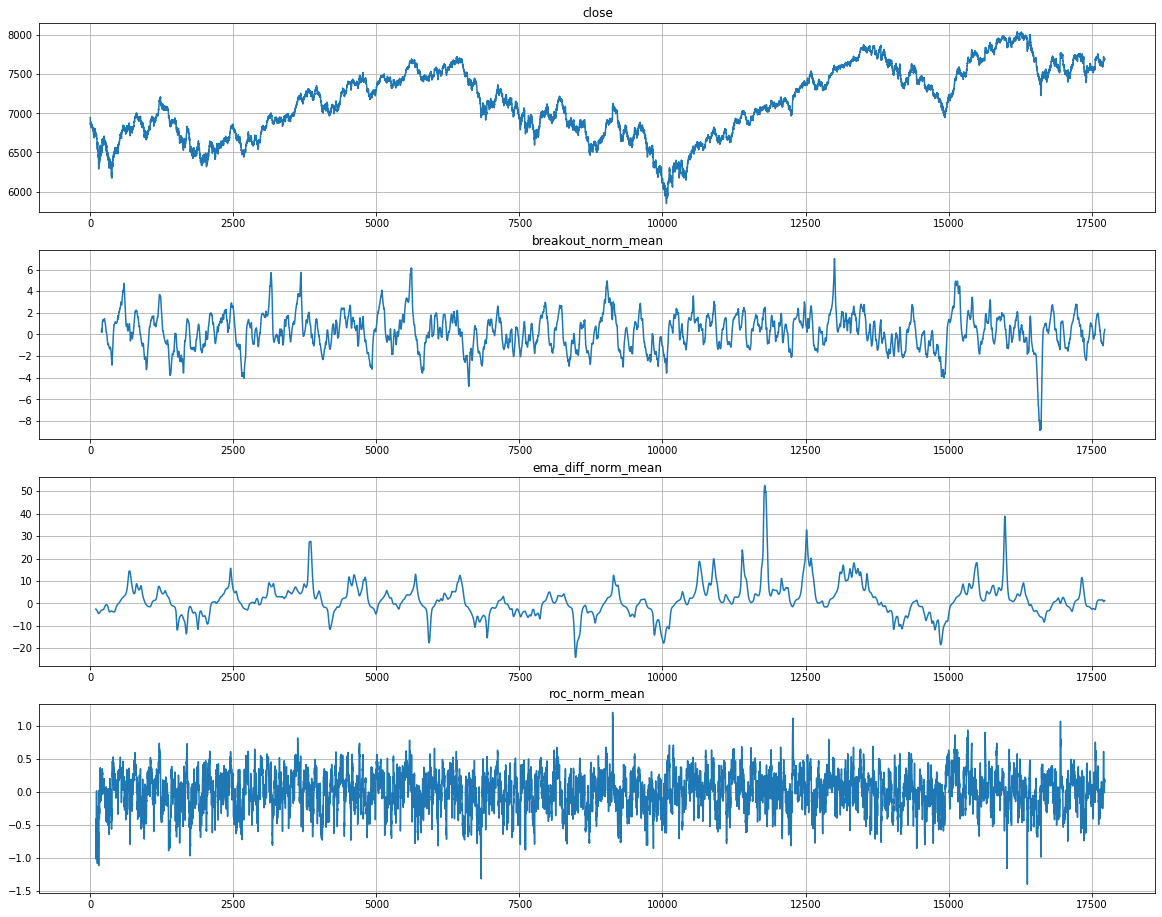

In [13]:
plot(data[['close', 'breakout_norm_mean', 'ema_diff_norm_mean','roc_norm_mean']])

In [14]:
data = data.iloc[periods*3:]

In [15]:
10 / data[['breakout_norm_mean', 'ema_diff_norm_mean', 'roc_norm_mean']].abs().mean()

breakout_norm_mean     7.532072
ema_diff_norm_mean     1.906339
roc_norm_mean         43.503898
dtype: float64

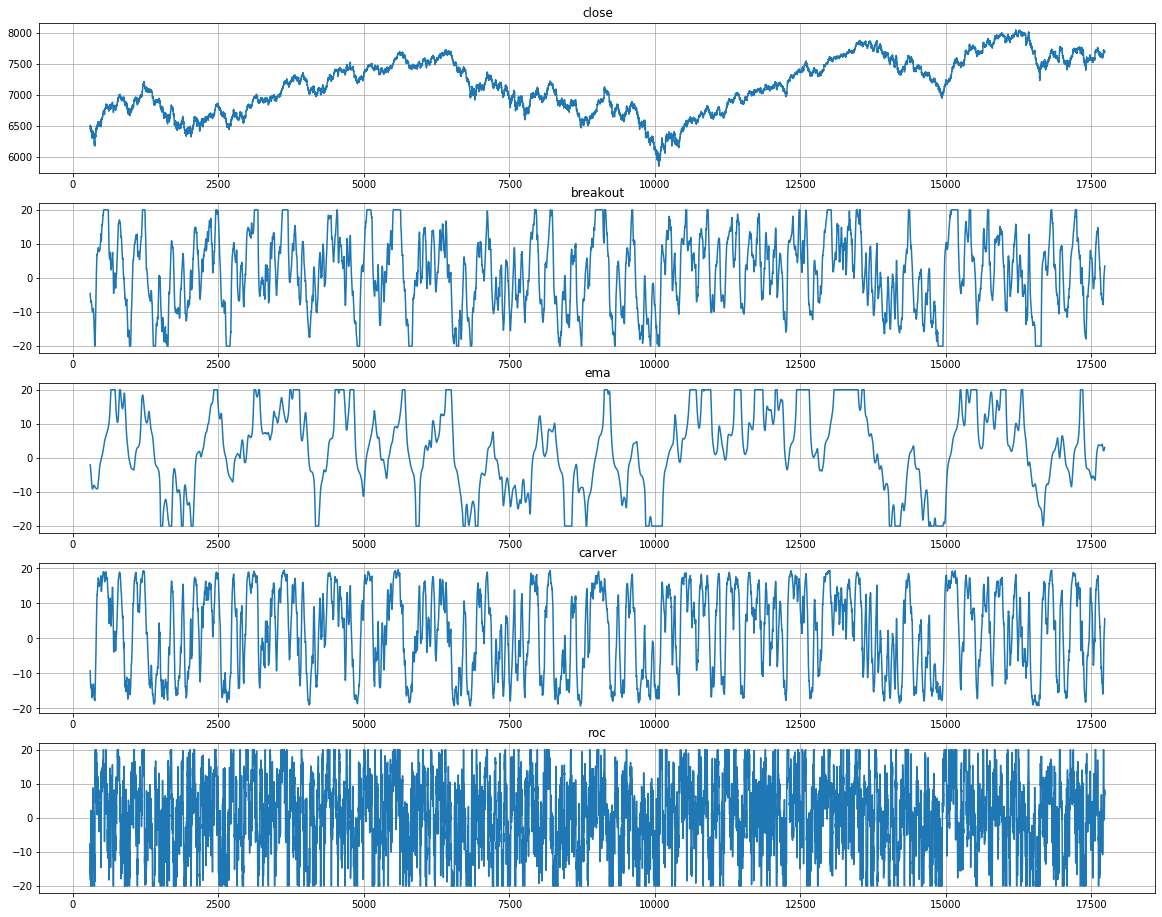

In [16]:
scaled = pd.DataFrame({'date': data.date,
                       'close': data.close,
                       'breakout': (data['breakout_norm_mean'] * 7.5).clip(lower=-20, upper=20),
                       'ema': (data['ema_diff_norm_mean'] * 2.4).clip(lower=-20, upper=20),
                       'carver': (data['carver_mean'] * 40).clip(lower=-20, upper=20),
                       'roc': (data['roc_norm_mean'] * 43).clip(lower=-20, upper=20)
                      })
plot(scaled[['close', 'breakout', 'ema', 'carver', 'roc']])

In [17]:
scaled[['breakout', 'ema', 'carver', 'roc']].corr()

,breakout,ema,carver,roc
breakout,1.000000,0.449702,0.957557,0.420700
ema,0.449702,1.000000,0.362538,0.060356
carver,0.957557,0.362538,1.000000,0.482211
roc,0.420700,0.060356,0.482211,1.000000


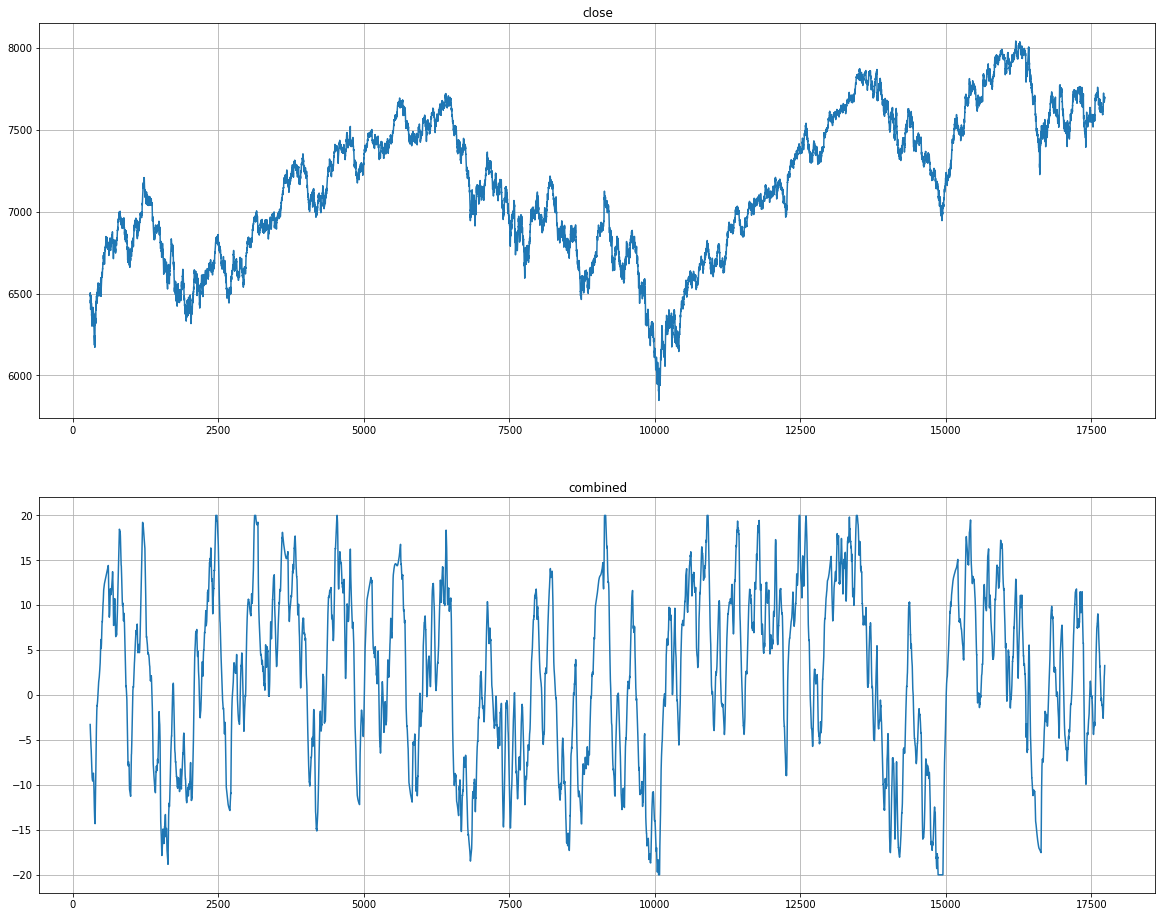

In [18]:
scaled['combined'] = scaled[['breakout', 'ema']].mean(axis=1)
plot(scaled[['close', 'combined']])

In [19]:
scaled.std()

close       438.852898
breakout     10.804541
ema          11.857983
carver       11.806325
roc          11.226448
combined      9.651185
dtype: float64

In [20]:
scaled[['breakout', 'ema', 'carver', 'roc', 'combined']].abs().mean()

breakout     9.246759
ema         10.090809
carver      10.672872
roc          9.342138
combined     8.446308
dtype: float64

In [21]:
10/scaled.std()

close       0.022787
breakout    0.925537
ema         0.843314
carver      0.847004
roc         0.890754
combined    1.036142
dtype: float64

In [22]:
scaled['combined'] = scaled['combined'] * 1.02

In [23]:
scaled.head()

,date,close,breakout,ema,carver,roc,combined
label,,,,,,,
300,2018-02-08 17:40:00,6487.25,-4.538362,-1.999764,-9.224866,-16.168217,-3.334444
301,2018-02-08 17:51:00,6498.25,-4.721150,-2.103268,-9.592493,-10.471747,-3.480453
302,2018-02-08 18:04:00,6505.50,-4.840575,-2.212661,-9.842073,-7.473356,-3.597151
303,2018-02-08 18:19:00,6468.50,-5.162558,-2.332843,-10.530587,-10.451011,-3.822655
304,2018-02-08 18:26:00,6441.75,-5.547172,-2.467517,-11.259003,-17.070161,-4.087491


In [24]:
scaled['combined'].std(), scaled['combined'].abs().mean()

(9.844208279930179, 8.61523460049618)

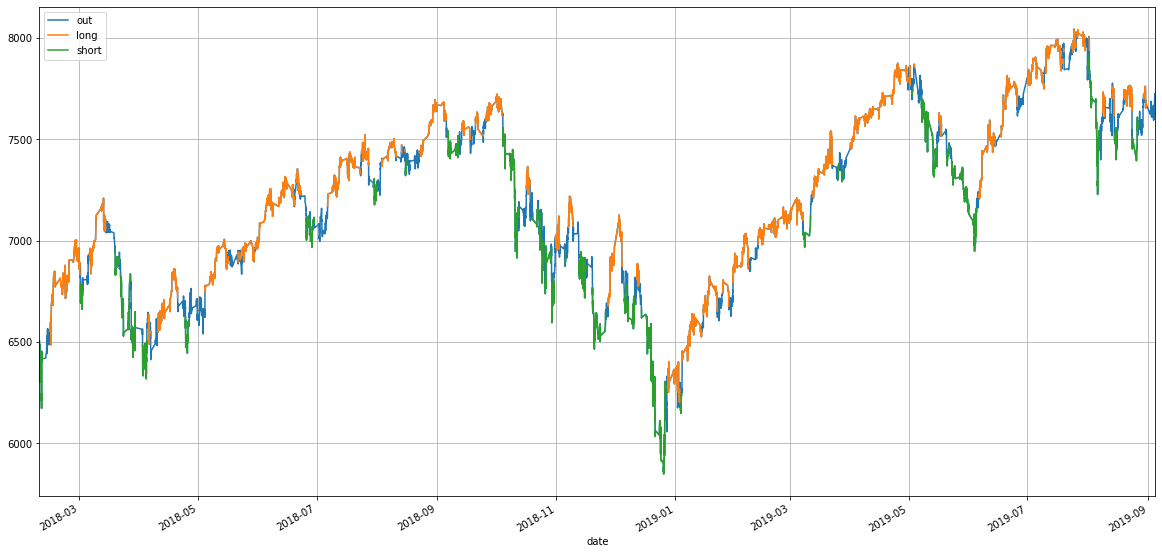

In [25]:
chart_data = data.set_index('date')
chart_scaled = scaled.set_index('date')
chart_price(chart_data.close, chart_scaled['combined'], 5, -5)

Annual return          0.655458
Cumulative returns     1.275333
Annual volatility      0.826083
Sharpe ratio           1.014129
Calmar ratio           1.662655
Stability              0.725650
Max drawdown          -0.394224
Omega ratio            1.208054
Sortino ratio          1.656398
Skew                   0.735821
Kurtosis               3.504657
Tail ratio             1.217426
Daily value at risk   -0.100752

Win percent               0.372549
Average gain           2293.421053
Average loss          -1062.109375
Avg gain/loss ratio       2.159308
Position EV             187.990196
Positions per day         0.248175
Days per position         4.029412
Days                    411.000000
Positions               102.000000
Trades                  203.000000


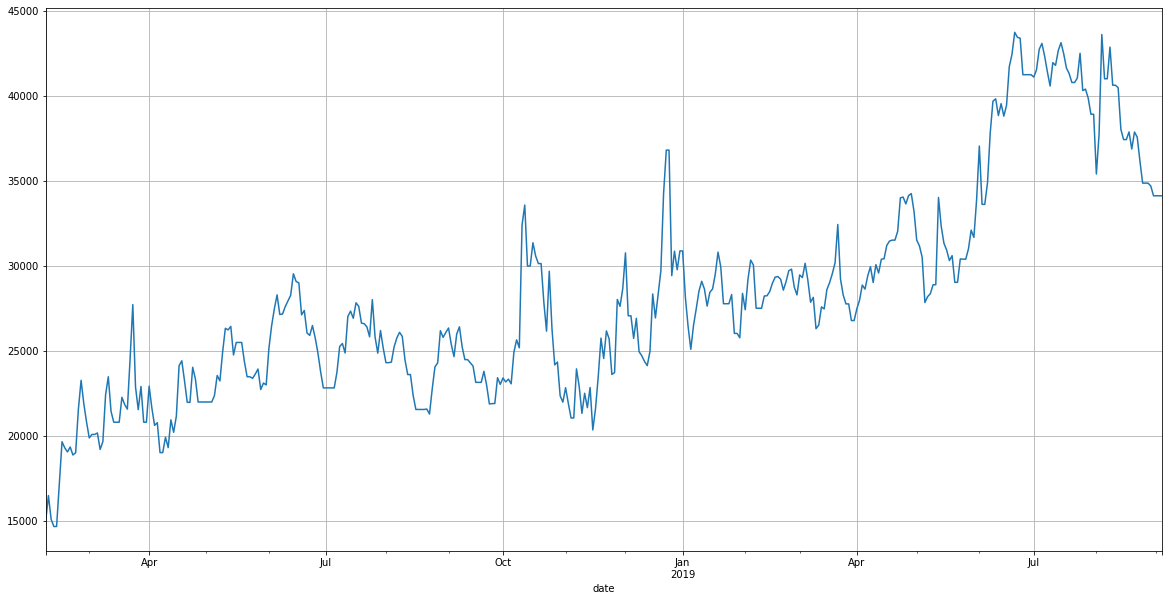

In [26]:
price = data.set_index('date')
ind = scaled.set_index('date')
results = backtest(price.open,
         ind.combined, 
         5, multiplier, bankroll)

In [27]:
results[1].sort_values('transaction_pnl').head(20)

,signal,cum_pnl_dollars,transaction_pnl
date,,,
2018-10-29 19:06:00,0.0,7215.0,-4085.0
2019-05-07 16:14:00,0.0,12845.0,-2670.0
2019-08-14 20:38:00,0.0,23005.0,-2635.0
2019-01-02 18:52:00,0.0,13355.0,-2515.0
2019-08-01 21:45:00,0.0,19995.0,-2140.0
2019-03-12 16:15:00,0.0,11305.0,-1995.0
2019-01-04 17:51:00,0.0,9480.0,-1965.0
2019-01-03 21:58:00,0.0,11445.0,-1910.0
2019-08-01 17:53:00,0.0,22135.0,-1795.0


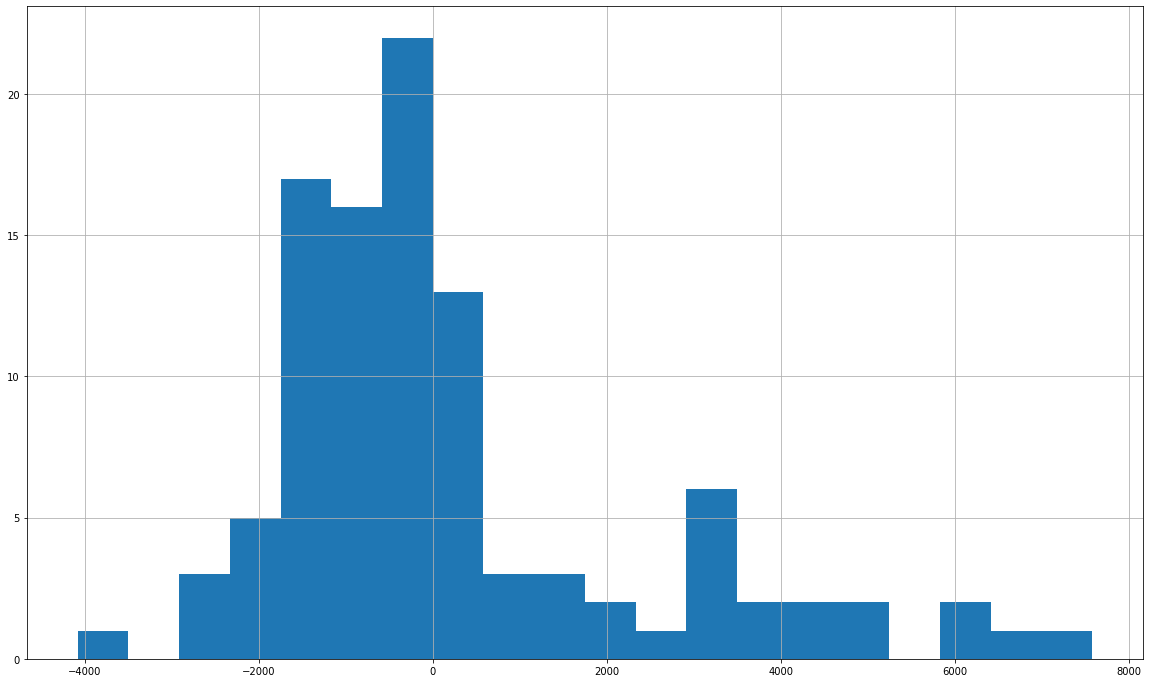

In [28]:
results[1]['transaction_pnl'].hist(bins=20, figsize=(20,12), grid=True);

In [29]:
results[0]

,balance,returns
date,,
2018-02-07,15000.0,0.000000
2018-02-08,16480.0,0.098667
2018-02-09,15080.0,-0.084951
2018-02-12,14660.0,-0.027851
2018-02-13,14660.0,0.000000
...,...,...
2019-08-29,34700.0,-0.005018
2019-08-30,34130.0,-0.016427
2019-09-02,34130.0,0.000000
